# Predicting Room Occupancy based on Sensor Data
by Matt Milunski

I have a few days off and some time to kill, so why not have a little fun with some machine learning?

This analysis uses sensor data from a room in an office building to detect an occupant. The goal is to predict when there is an occupant in the room based on the sensor data. Credit goes to Luis M. Candanedo for curating the data and submitting it to the UCI Machine Learning Repository. I have not read the paper that used these data, but feel free to [purchase a copy of it](https://www.sciencedirect.com/science/article/pii/S0378778815304357).

This analysis is for some R-related demonstration purposes. If you have any feedback, feel free to shoot me a message on [my LinkedIn page](https://www.linkedin.com/in/matt-milunski-35120655/).

## Set Up
One of the first things I'll do is load the packages that I'd like to use for analysis. After that, I will load the data into memory and make some adjustments to make working with the data easier.

### Packages
I'll be using the tidyverse for data manipulation and plotting, lubridate for easier handling of dates, and caret for the machine learning tasks. XGBoost is listed in the `pkg_list` object as this is my first time installing it.

In [35]:
# packages ----
pkg_list = list("tidyverse", "xgboost", "lubridate", "caret")

# install packages if not found in library and load ----
lapply(pkg_list, function (x) {
    if(!is.element(x, installed.packages()[, 1])) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE)
        show(paste(x, "installed and loaded."))
    } else {
        library(x, character.only = TRUE)
        show(paste(x, "loaded."))
    }
})

[1] "tidyverse loaded."
[1] "xgboost loaded."
[1] "lubridate loaded."
[1] "caret loaded."


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

### Data Loading and Preparation
There are three data files used in this analysis:
1. datatest.txt
2. datatest2.txt
3. datatraining.txt

Here is the data dictionary:
1. `date`, date-time of sensor's recording, time year-month-day hour:minute:second 
2. `Temperature`, room temperature, Celsius 
3. `Humidity`, relative humidity, percentage
4. `Light`, light measurement, in Lux 
5. `CO2`, carbon dioxide concentration, in ppm 
6. `HumidityRatio`, derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air 
7. `Occupancy`, 0 or 1, 0 for not occupied, 1 for occupied status

The sensor data are recorded nearly every minute, so each observation constitutes 60-second intervals.

In [2]:
# load data function ---
read_data = function(data_path) {
    require(dplyr)
    data_ingest = read.csv(data_path, header = TRUE, stringsAsFactors = FALSE, 
                           sep = ",")
    obj_name = regmatches(data_path, regexpr("[^/]+$", data_path))
    clean_name = gsub("\\.|txt", "", obj_name)
    assign(x = clean_name, value = data_ingest, envir = .GlobalEnv)
    print(paste(clean_name, "loaded into .GlobalEnv"))
}

# load data ----
lapply(list.files("/Users/mattmilunski/Dropbox/Analytics/occupancy data", 
                  pattern = "txt", full.names = TRUE), read_data)

[1] "datatest loaded into .GlobalEnv"
[1] "datatest2 loaded into .GlobalEnv"
[1] "datatraining loaded into .GlobalEnv"


[[1]]
[1] "datatest loaded into .GlobalEnv"

[[2]]
[1] "datatest2 loaded into .GlobalEnv"

[[3]]
[1] "datatraining loaded into .GlobalEnv"

In [3]:
# take a peek at the data ----
glimpse(datatraining)
glimpse(datatest)
glimpse(datatest2)

Observations: 8,143
Variables: 7
$ date          <chr> "2015-02-04 17:51:00", "2015-02-04 17:51:59", "2015-0...
$ Temperature   <dbl> 23.180, 23.150, 23.150, 23.150, 23.100, 23.100, 23.10...
$ Humidity      <dbl> 27.27200, 27.26750, 27.24500, 27.20000, 27.20000, 27....
$ Light         <dbl> 426.0, 429.5, 426.0, 426.0, 426.0, 419.0, 419.0, 419....
$ CO2           <dbl> 721.2500, 714.0000, 713.5000, 708.2500, 704.5000, 701...
$ HumidityRatio <dbl> 0.004792988, 0.004783441, 0.004779464, 0.004771509, 0...
$ Occupancy     <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,...
Observations: 2,665
Variables: 7
$ date          <chr> "2015-02-02 14:19:00", "2015-02-02 14:19:59", "2015-0...
$ Temperature   <dbl> 23.7000, 23.7180, 23.7300, 23.7225, 23.7540, 23.7600,...
$ Humidity      <dbl> 26.2720, 26.2900, 26.2300, 26.1250, 26.2000, 26.2600,...
$ Light         <dbl> 585.2000, 578.4000, 572.6667, 493.7500, 488.6000, 568...
$ CO2           <dbl> 749.2000, 760.4000, 769.6667, 774.7500, 779

I'm not entirely sure what the two testing sets are for. Since I'm not working with a lot of data, I'm going to implement a repeated *k*-fold cross-validation method instead of using a hold-out.

In [4]:
# combine all data ----
full_data = bind_rows(datatraining, datatest, datatest2)

# check: new_train row count must equal sum of row count for both datasets ----
nrow(full_data) == nrow(datatraining) + nrow(datatest) + nrow(datatest2)

[1] TRUE

I find camelhump variable names to be somewhat annoying to work with, so I'll modify them in both the training and test data.

In [5]:
# variable name fix ----
fix_names = function(dataset) {
    names(dataset) = gsub("([[:lower:]])([[:upper:]])", "\\1_\\2", 
                          names(dataset))
    names(dataset) = tolower(names(dataset))
}

# fix names ----
names(full_data) = fix_names(full_data)

Check the names just to be sure...

In [6]:
names(full_data)

[1] "date"           "temperature"    "humidity"       "light"         
[5] "co2"            "humidity_ratio" "occupancy"

## Exploratory Data Analysis & Feature Engineering
Before the actual algorithm implementation, I'm going to do some exploratory analysis to get a better look at the data. It's important to limit this exploration to the training data and not to explore the test data.

### Occupancy Related to the Dates
Occupancy of the room may be related to the day of week.

In [7]:
# fix date field and extract day of week ----
full_data = full_data %>% 
        mutate(date = ymd_hms(date), 
               day_of_week = wday(date, label = TRUE))

Warning message in as.POSIXlt.POSIXct(x, tz):
“unknown timezone 'zone/tz/2018c.1.0/zoneinfo/America/Chicago'”

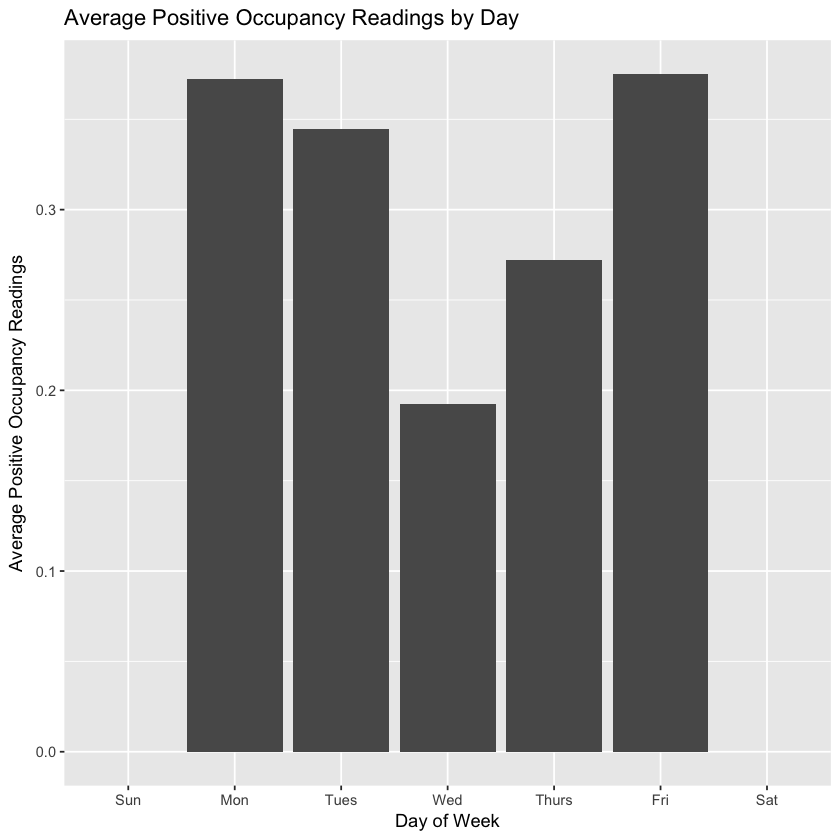

In [8]:
# average positive readings by day of week ----
full_data %>% 
        group_by(day_of_week) %>% 
        summarise(mean_occupancy = mean(occupancy, na.rm = TRUE)) %>% 
        ggplot(aes(x = day_of_week, y = mean_occupancy)) + geom_col() + 
            labs(x = "Day of Week", y = "Average Positive Occupancy Readings",
            title = "Average Positive Occupancy Readings by Day")

The room is primarily occupied during the on Mondays and Fridays. Weekends have no positive occupation readings. Wednesday is oddly low. Instead of looking at just days, it may help to look at each day and the occupancy by hour.

### Hourly Occupancy by Day
To get a better idea of what's happening during each weekday, I'm plotting the mean hourly occupancy by each day. This way I can see on average how often the room is occupied in one-hour intervals.

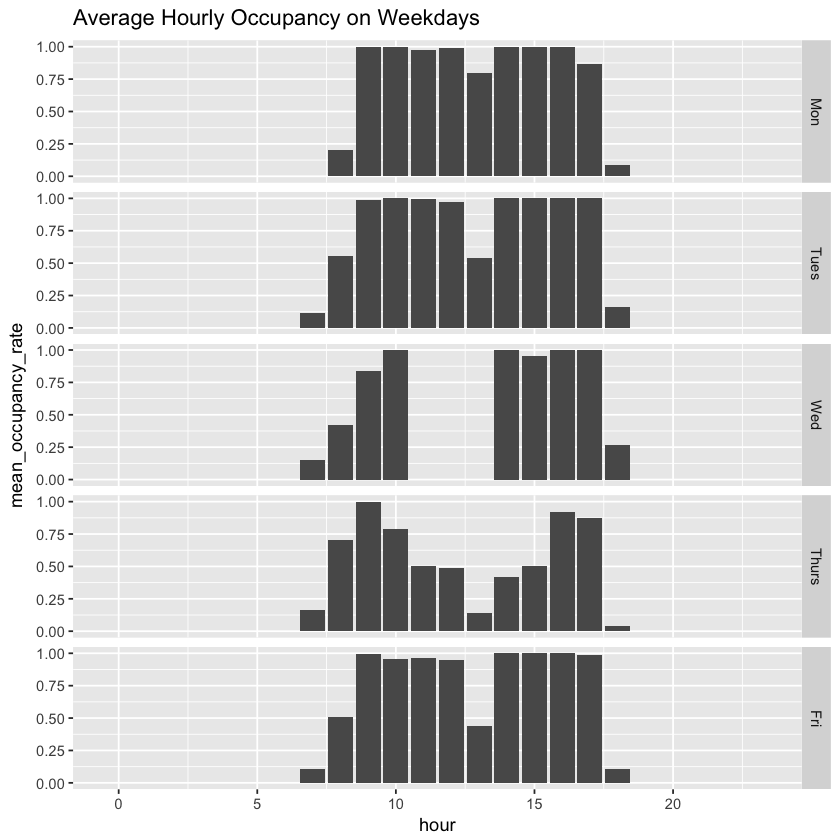

In [9]:
# parse out the time from `date` ----
full_data = full_data %>% 
        mutate(hour = hour(date), 
               minute = minute(date), 
               second = second(date))

# plots ----
full_data %>% 
        filter(!day_of_week %in% c("Sat", "Sun")) %>% 
        group_by(day_of_week, hour) %>% 
        summarise(mean_occupancy_rate = mean(occupancy, na.rm = TRUE)) %>% 
        ggplot(aes(x = hour, y = mean_occupancy_rate)) + geom_col() + 
            facet_grid(day_of_week ~ .) +
            labs(title = "Mean Hourly Occupancy on Weekdays")
        

It looks like the activity is primarily happening between 07:00 and 18:00, which approximates normal working hours. 13:00 to 14:00 seems to have a much lower occupancy average than the other time blocks (excluding the tails when people would normally get to work or leave). Must be lunch time or time for table tennis.

### Light, CO$_{2}$, and Temperature
Common sense would suggest that light's lux level, CO$_{2}$ concentration, and temperature would all increase in the presence of an occupant. People usually have to turn on lights and breathe (thus exhaling CO$_{2}$). People can also raise a room's temperature merely by their presence in the room. I'll make a few plots to investigate the relationships.

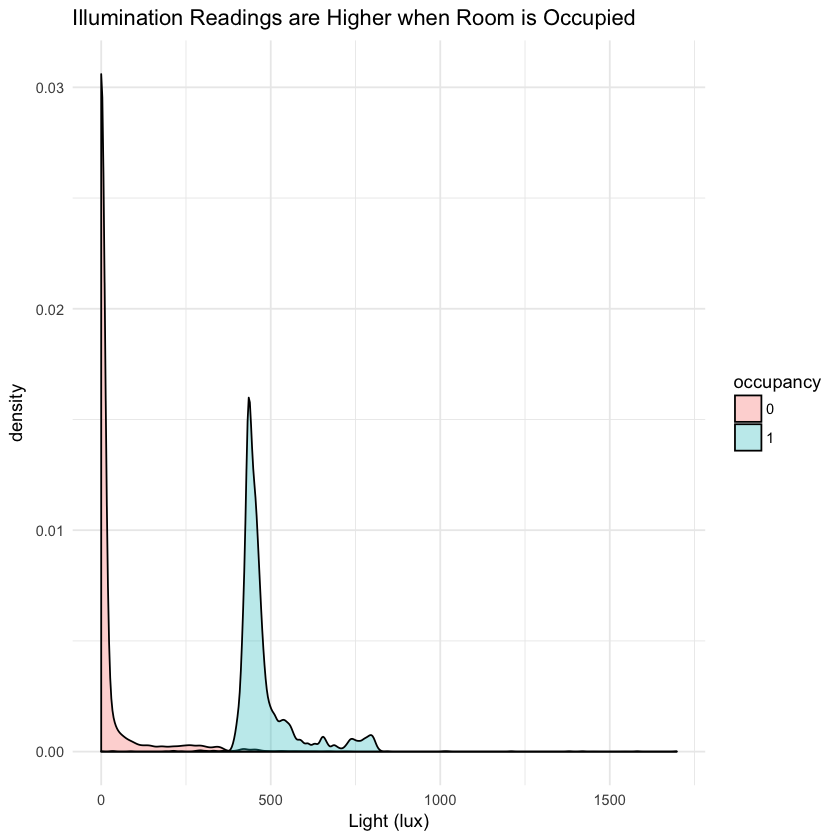

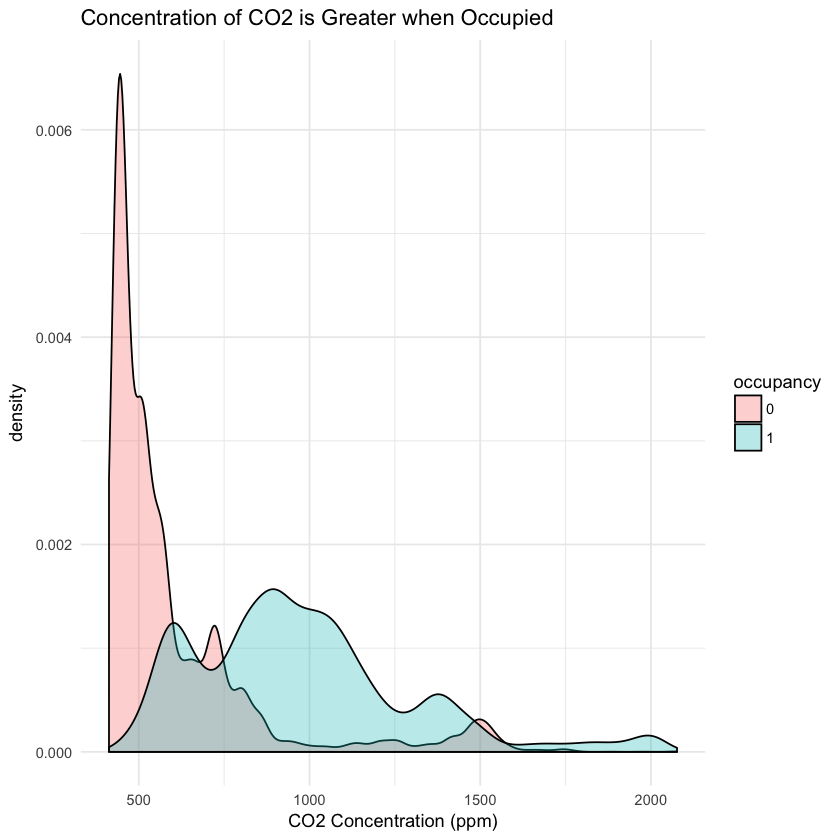

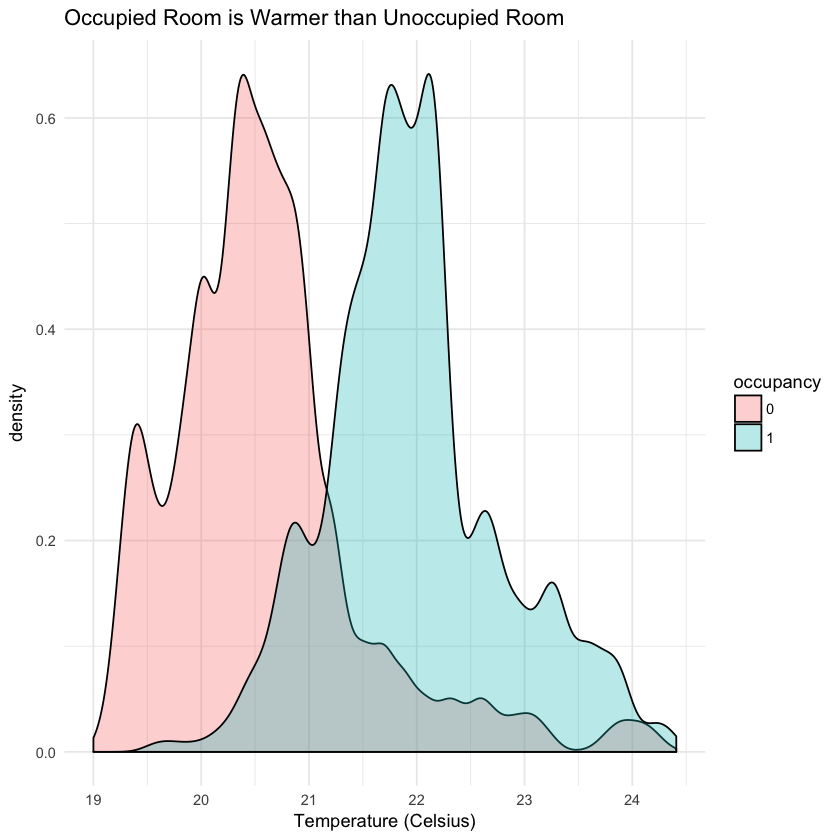

In [87]:
# light ----
full_data %>% 
        mutate(occupancy = as.factor(occupancy)) %>% 
        ggplot(aes(x = light, fill = occupancy)) + 
        geom_density(alpha = 0.3) + 
        labs(title = "Illumination Readings are Higher when Room is Occupied",
             x = "Light (lux)") +
        theme_minimal()

# co2 ----
full_data %>% 
        mutate(occupancy = as.factor(occupancy)) %>%
        ggplot(aes(x = co2, fill = occupancy)) + 
        geom_density(alpha = 0.3) + 
        labs(title = "Concentration of CO2 is Greater when Occupied", 
             x = "CO2 Concentration (ppm)") +
        theme_minimal()

# Temperature ----
full_data %>% 
        mutate(occupancy = as.factor(occupancy)) %>%
        ggplot(aes(x = temperature, fill = occupancy)) + 
        geom_density(alpha = 0.3) + 
        labs(title = "Occupied Room is Warmer than Unoccupied Room",
             x = "Temperature (Celsius)") +
        theme_minimal()

### What EDA Has Revealed
The EDA has revealed a few key patterns that helped produce some features. 

1. There's no occupancy activity on the weekends. As a result, extracting the day of the week that was associated with each observation will could help in improving the classification. 
2. Occupancy signals happen at set hours - typically "working hours". Similar to the day of the week, the hour was extracted from the date in order to determine if an observation occured during working hours. 
3. Light, CO$_{2}$ levels, and room temperature were all greater when the room was occupied.

There are probably more complex relationships to unveil, but on to the model training.

## Machine Learning Models
Now it's time to prep the data for model fitting, implement a few machine learning models, and compare their performance. I'll try the following models:
- [Random Forest](https://en.wikipedia.org/wiki/Random_forest)
- [Extreme Gradient Boosting (XGBoost)](https://en.wikipedia.org/wiki/Xgboost)

Both models have a great track record for regression and classification problems.

### Select Relevant Features
Before moving into the model fitting portion, I need to select the features I want for analysis. I also need to recode `occupancy` to a categorical variable as this is a classification problem and caret will throw an error at me for not doing so. 

In [14]:
# preprocess data ----
modeling_data = full_data %>% 
        select(temperature, humidity, light, co2, humidity_ratio, day_of_week,
               hour, occupancy) %>% 
        mutate(occupancy = ifelse(occupancy == 1, "yes", "no"))

# check both datasets ----
head(modeling_data, 3)

temperature,humidity,light,co2,humidity_ratio,day_of_week,hour,occupancy
23.18,27.2720,426.0,721.25,0.004792988,Wed,17,yes
23.15,27.2675,429.5,714.00,0.004783441,Wed,17,yes
23.15,27.2450,426.0,713.50,0.004779464,Wed,17,yes


### Training with Random Forest and XGBoost
Now it's time to train the models with the two algorithms. 

In [19]:
# models ----
ml_models = c("rf", "xgbTree")

# model execution ----
for (i in seq_along(ml_models)) {
    # create control parameters ----
    controls = trainControl(method = "repeatedcv", number = 10, repeats = "3",
                            classProbs = TRUE, summaryFunction = twoClassSummary)
    
    # set seed again and train model ----
    set.seed(123)
    train_model = train(occupancy ~ ., modeling_data, method = ml_models[i], 
                        metric = "ROC", verbose = FALSE, trControl = controls)
    
    # assign results ----
    assign(x = paste0(ml_models[i], "_output"), value = train_model)
}

Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following object is masked from ‘package:lubridate’:

    here

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:purrr’:

    compact



### Model Comparison
Let's compare models. I'm using the Receiver Operating Characteristic (ROC) metric as the measure of each model's performance. Needless to say, both algorithms performed similarly well with the data.

In [34]:
list(XGBoost = xgbTree_output, RandomForest = rf_output) %>% 
        resamples() %>% 
        summary()


Call:
summary.resamples(object = .)

Models: XGBoost, RandomForest 
Number of resamples: 30 

ROC 
                  Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
XGBoost      0.9983821 0.9991145 0.9994544 0.9993358 0.9995865 0.9999041    0
RandomForest 0.9983954 0.9992962 0.9996358 0.9994654 0.9997810 0.9999194    0

Sens 
                  Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
XGBoost      0.9873498 0.9932005 0.9943074 0.9939068 0.9949399 0.9974700    0
RandomForest 0.9911448 0.9936749 0.9949399 0.9948134 0.9960468 0.9981025    0

Spec 
                  Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
XGBoost      0.9831579 0.9894737 0.9915789 0.9917895 0.9936842 1.0000000    0
RandomForest 0.9768421 0.9857895 0.9915789 0.9898246 0.9936842 0.9978947    0


### Variable Importance
Below are the variable importance plots for both the Random Forest and XGBoost models.

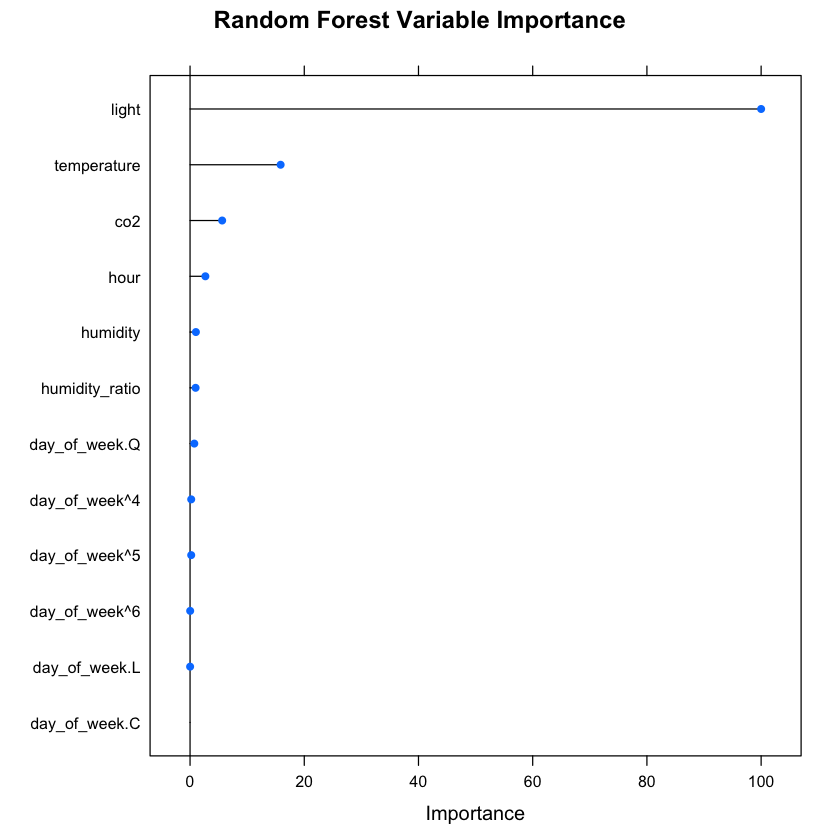

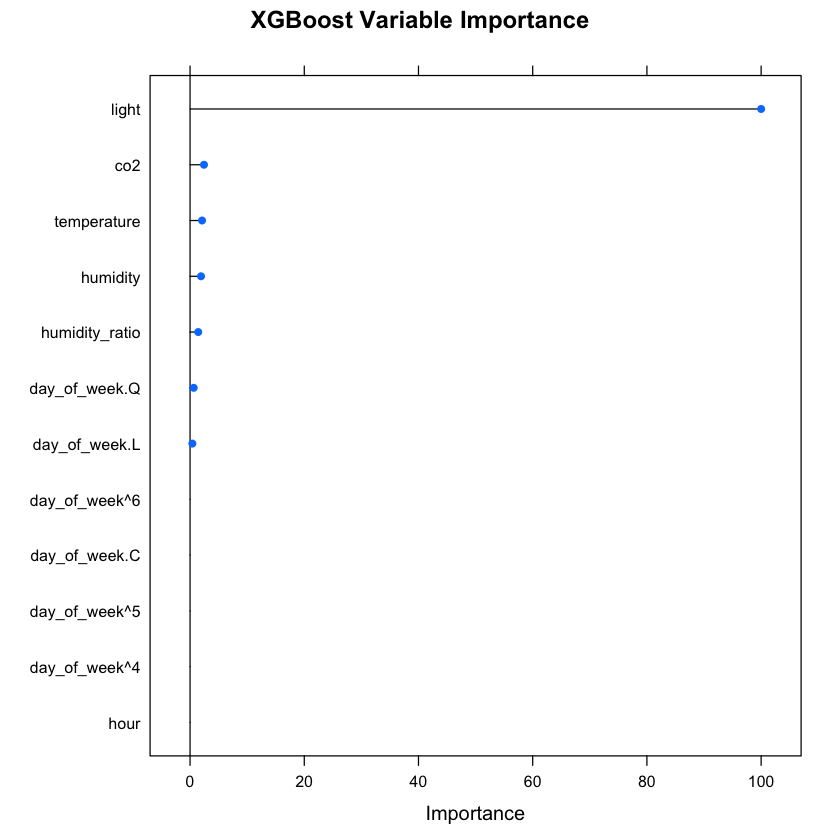

In [74]:
# rf ----
plot(varImp(rf_output), main = "Random Forest Variable Importance")

# xgboost ----
plot(varImp(xgbTree_output), main = "XGBoost Variable Importance")

## Conclusion

At this point, either model is a viable candidate. Technically, Random Forest has the best ROC (at the ten-thousandths place), but it really depends on the purpose of this analysis. 

If this analysis is just about saving energy on a light bill (so you know when to automate a light shutoff process), then I'd go with Random Forest simply because of its ROC. 

However, if detecting an unauthorized person (e.g., burglar) in a room is of importance, then you'll probably want to pick a model that produces less false negatives (predicting someone isn't in the room when someone really is in the room). If that's the case, then I would use XGBoost as it has a higher mean specificity value (again, not much higher than RF). Based on the model performance, XGBoost should yield more false positives, however the cost of a false negative could be considerable. 

If you've made it this far, thanks for reading!